# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import h5py
import yaml
import casatasks
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
obs = conf["obs list"][1]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

ms = os.path.join(root, f"{obs}.ms")
vladata.listobs(ms)

BeginTime
58741.80712962962 

EndTime
58741.88398148149 

IntegrationTime
6640.000001907349 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 1.4948845339}, 'm1': {'unit': 'rad', 'value': 0.8700817014000001}, 'refer': 'J2000', 'type': 'direction'}
name :  3C147


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.8707328287}, 'm1': {'unit': 'rad', 'value': -0.4287152683}, 'refer': 'J2000', 'type': 'direction'}
name :  J1057-2433


field_10
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.6722909513795865}, 'm1': {'unit': 'rad', 'value': 0.2145021233}, 'refer': 'J2000', 'type': 'direction'}
name :  J1347+1217


field_11
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.6959439184795864}, 'm1': {'unit': 'rad', 'value': 0.1654116891}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1342+0928


field_2
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.7697284398}, 'm1': {'unit': 'rad', 'value': -0.2516938345}, 'refer':

### Array Layout

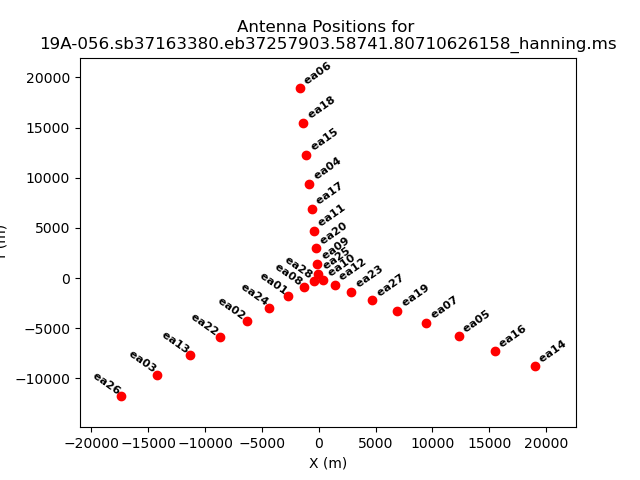

In [3]:
Image(filename=root + "/plots/obsplots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

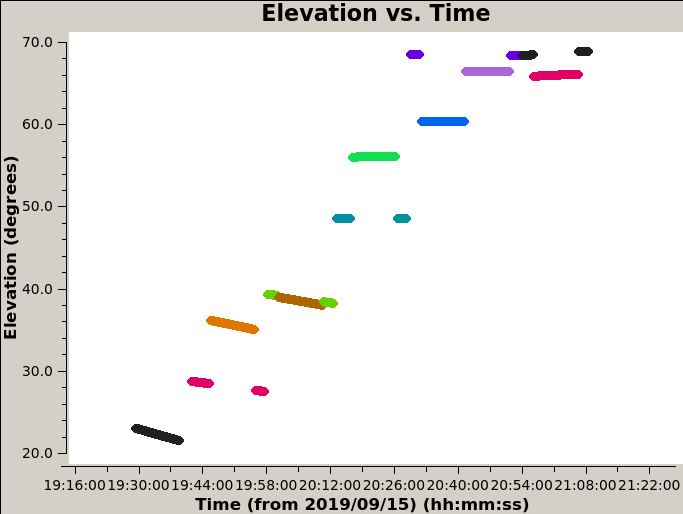

In [4]:
Image(filename=root + "/plots/obsplots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

In [5]:
summary_before = np.load(root + "/output/detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/detflag_summary_after.npy", allow_pickle='TRUE').item()

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
print("Flag occupancy (percent) before and after deterministic flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field 3C147
Before: 36.3357, After: 49.6085

field J1057-2433
Before: 35.6709, After: 48.6051

field J1130-1449
Before: 16.6981, After: 33.4382

field J1246-0730
Before: 17.5671, After: 34.1113

field J1309+1154
Before: 23.0897, After: 38.5024

field J1347+1217
Before: 16.0921, After: 32.9387

field QSO J1034-1425
Before: 6.5930, After: 25.3261

field QSO J1110-1329
Before: 5.0797, After: 24.1343

field QSO J1254-0014
Before: 6.5487, After: 25.2888

field QSO J1306+0356
Before: 6.7947, After: 25.4818

field QSO J1319+0950
Before: 5.9436, After: 24.8055

field QSO J1342+0928
Before: 4.4206, After: 23.5877

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 17.3399, After: 33.9260

scan 11
Before: 6.5487, After: 25.2888

scan 12
Before: 17.9294, After: 34.4068

scan 13
Before: 33.6432, After: 46.9030

scan 14
Before: 6.7947, After: 25.4818

scan 15
Before: 5.9436, After: 24.8055

scan 16
Before: 10.3968, After: 28.398

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

In [6]:
if os.path.exists(root+"/plots/dataplots/flaggingreason_vs_time.png"):
    Image(filename=root+"/plots/dataplots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

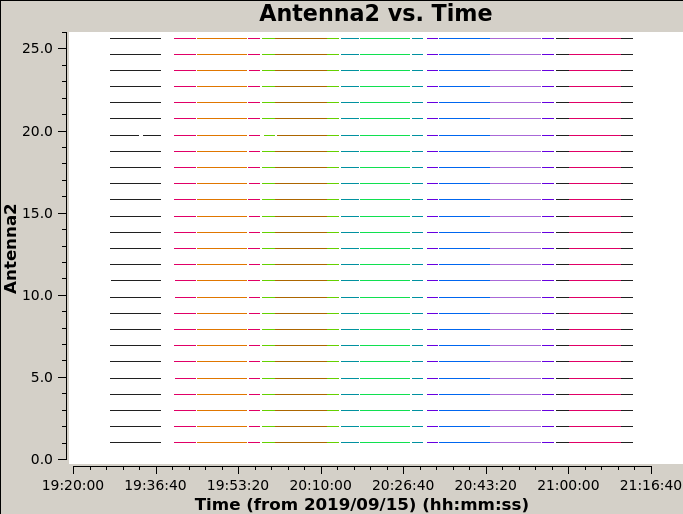

In [7]:
Image(filename=root + "/plots/obsplots/data_stream.png")

## Find Dead Antennas
Antennas that have low power should be flagged. This is also a good time to check for suitable reference antennas.

In [8]:
def plot_dead_ants(ant):
    plotfile = root + f"/plots/dataplots/find_dead_ants_amp_vs_freq_ant_{ant}.png"
    img = mpimg.imread(plotfile)
    plt.imshow(img)
    
interact(plot_dead_ants, ant=(1, 26))
    

interactive(children=(IntSlider(value=13, description='ant', max=26, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_dead_ants(ant)>

## RFI Inspection
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Use this to identify one clean channel per spectral window which will be used for the initial gain calibration.

#### Load Data

In [9]:

with h5py.File(root + f"/output/z_score_data.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

#### Plot

<IPython.core.display.Javascript object>


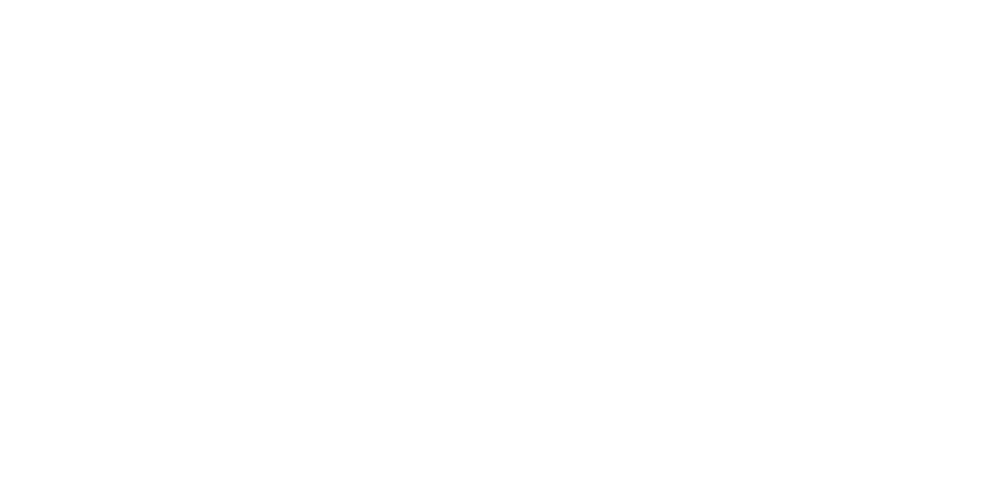

In [10]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

<IPython.core.display.Javascript object>


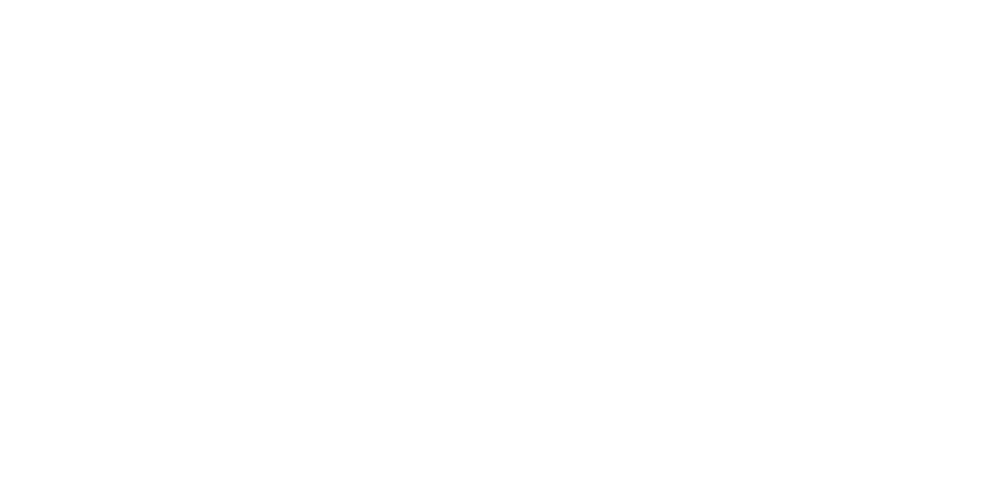

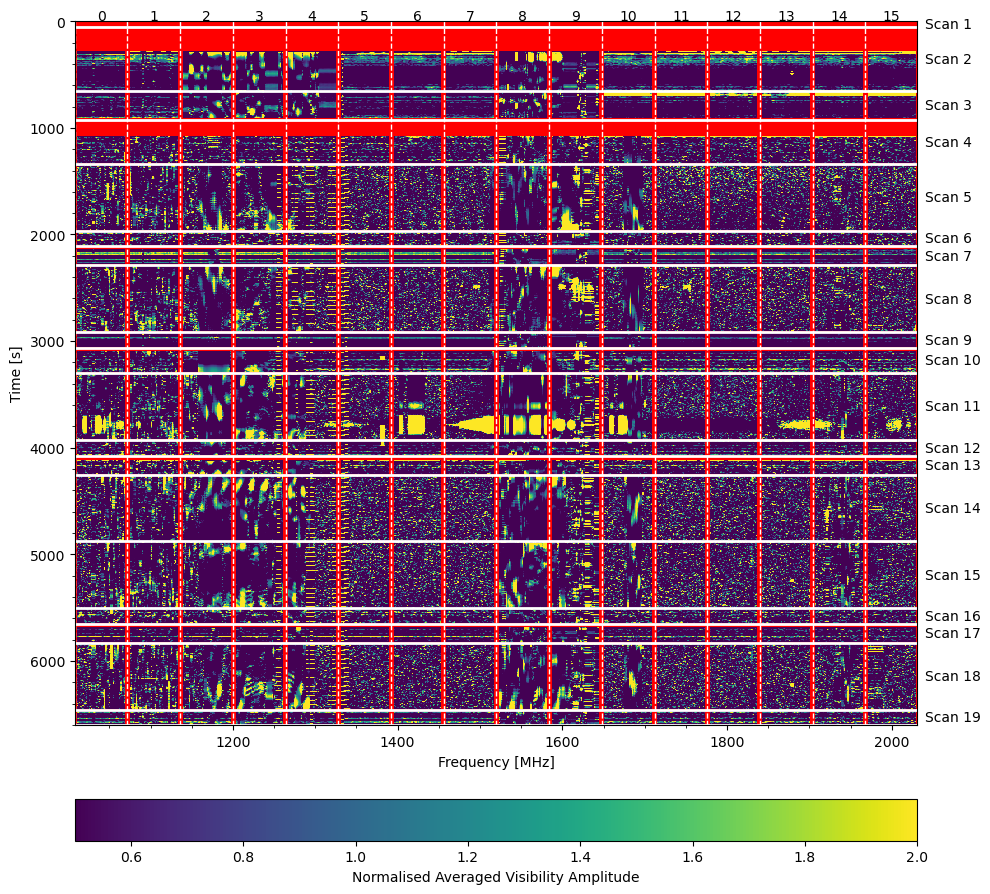

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=0.5, vmax=2, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")

In [12]:
def plot_wf_spw(i):
    inspect.plot_wf_spw(freq_array, z_score, i, 2, ntimes, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>

#### Manual Flagging
Applay manual time and frequency flags based on plots above.

In [13]:
"""
casatasks.flagdata(ms, timerange="2019/09/18/12:18:30~2019/09/18/12:18:55", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:27:59~2019/09/18/12:28:30", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:36:11~2019/09/18/12:36:15", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:36:31~2019/09/18/12:36:47", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:38:29~2019/09/18/12:38:35", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:41:09~2019/09/18/12:41:17", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:43:09~2019/09/18/12:43:13", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:51:29~2019/09/18/12:51:33", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:53:27~2019/09/18/12:53:29", reason="Manual Time Range Flagging", flagbackup=False)
"""

'\ncasatasks.flagdata(ms, timerange="2019/09/18/12:18:30~2019/09/18/12:18:55", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:27:59~2019/09/18/12:28:30", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:36:11~2019/09/18/12:36:15", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:36:31~2019/09/18/12:36:47", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:38:29~2019/09/18/12:38:35", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:41:09~2019/09/18/12:41:17", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:43:09~2019/09/18/12:43:13", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:51:29~2019/09/18/12:51:33

In [14]:
summary_before = np.load(root + "/output/manual_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/manual_flags_summary_after.npy", allow_pickle='TRUE').item()
        
print("Flag occupancy (percent) before and after manual flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after manual flags:

field 3C147
Before: 49.6085, After: 51.0740

field J1057-2433
Before: 48.6051, After: 51.0837

field J1130-1449
Before: 33.4382, After: 36.3146

field J1246-0730
Before: 34.1113, After: 36.1821

field J1309+1154
Before: 38.5024, After: 43.6597

field J1347+1217
Before: 32.9387, After: 36.4179

field QSO J1034-1425
Before: 25.3261, After: 27.1770

field QSO J1110-1329
Before: 24.1343, After: 26.1224

field QSO J1254-0014
Before: 25.2888, After: 26.6830

field QSO J1306+0356
Before: 25.4818, After: 27.8988

field QSO J1319+0950
Before: 24.8055, After: 26.4508

field QSO J1342+0928
Before: 23.5877, After: 25.4770

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 33.9260, After: 36.6745

scan 11
Before: 25.2888, After: 26.6830

scan 12
Before: 34.4068, After: 35.3969

scan 13
Before: 46.9030, After: 52.0225

scan 14
Before: 25.4818, After: 27.8988

scan 15
Before: 24.8055, After: 26.4508

scan 16
Before: 28.3989, After: 33.6

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

In [15]:
setjy = np.load(root + "/output/setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 28.13, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 26.94, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 25.85, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 24.85, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 23.92, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 23.06, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 22.27, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 21.52, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 20.83, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 20.18, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 19.57, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 19.00, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 18.46, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 17.95, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 17.47, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 17.02, U: 0.00, V: 0.00, Q: 0.00


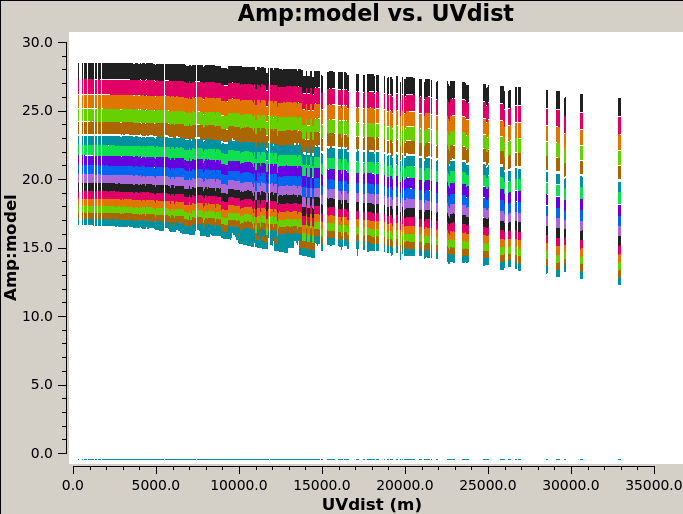

In [16]:
Image(filename=root + "/plots/calplots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

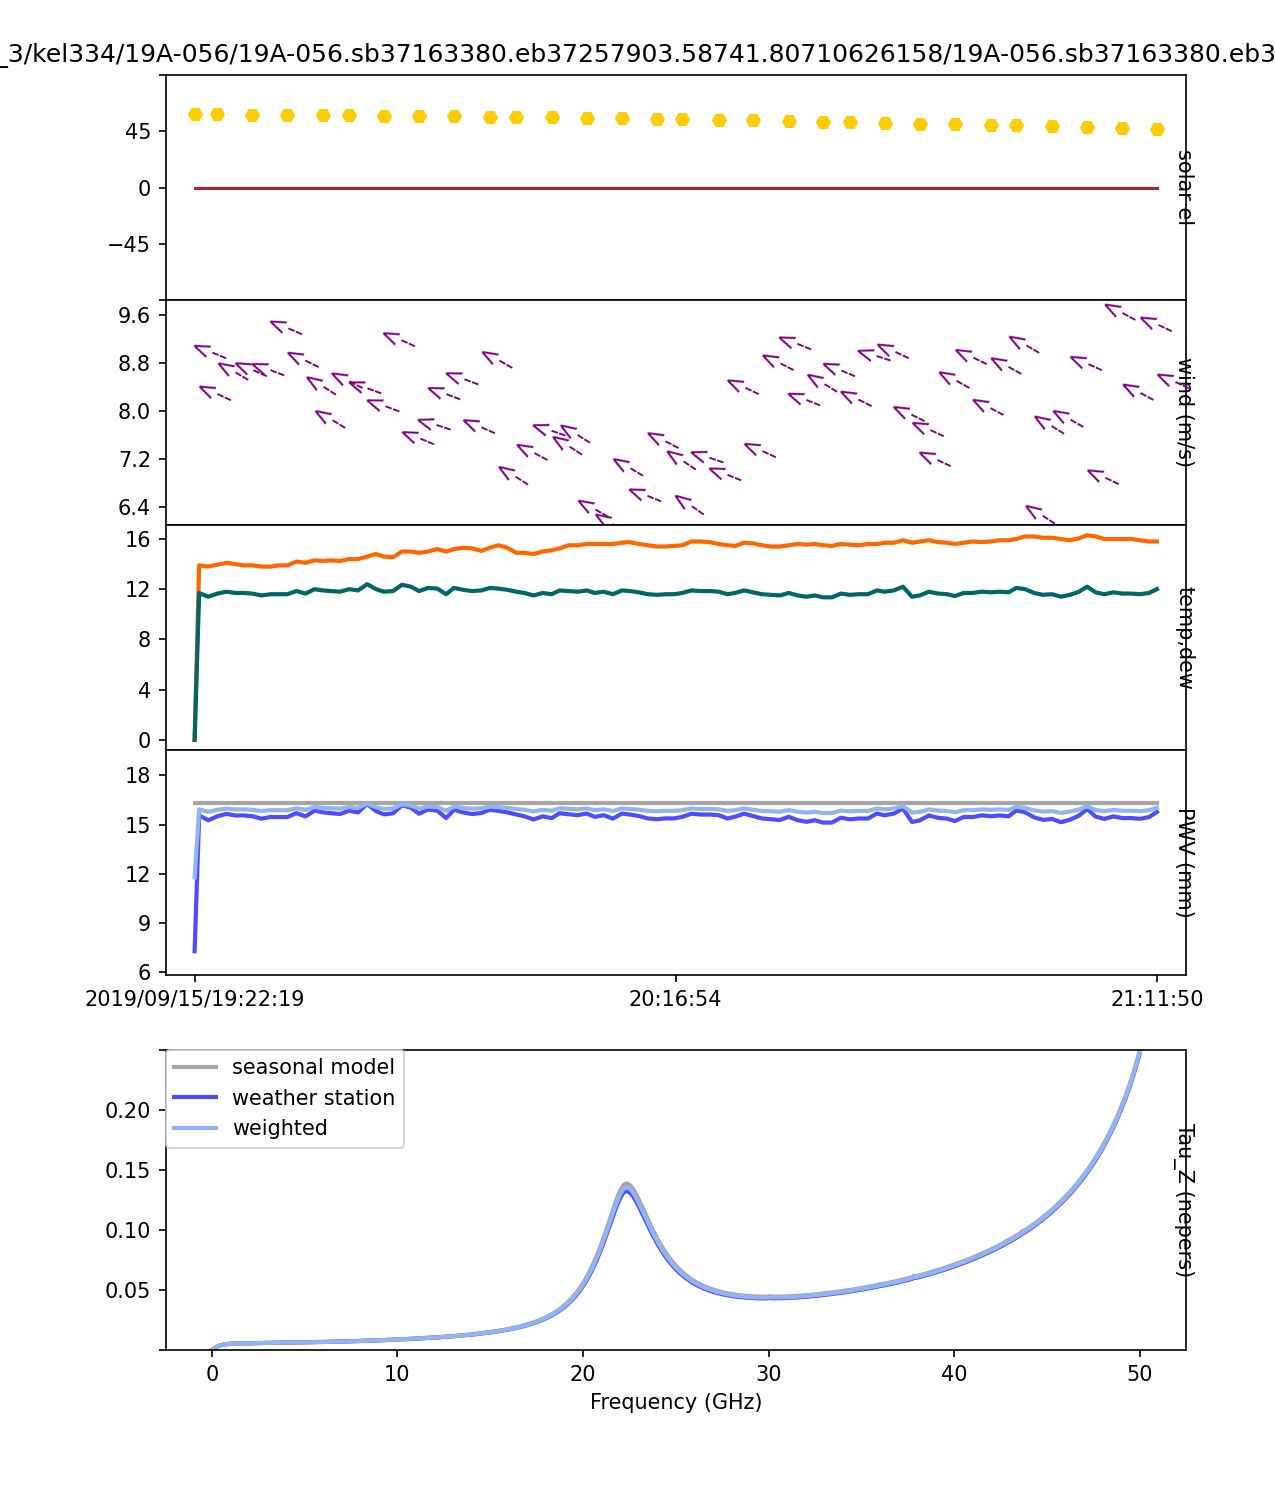

In [17]:
Image(filename=root + "/plots/calplots/weather.png")

In [18]:
opacities = np.load(root + "/output/weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.005155720330169471
SPW 1: 0.005215975540356473
SPW 2: 0.0052684612708354525
SPW 3: 0.005314402490744539
SPW 4: 0.005355236511163486
SPW 5: 0.005391560722944433
SPW 6: 0.005424306055528999
SPW 7: 0.005453947175697299
SPW 8: 0.005481013436487306
SPW 9: 0.005505911649112115
SPW 10: 0.005528932317589208
SPW 11: 0.005550422139566428
SPW 12: 0.0055705301911465775
SPW 13: 0.005589535562971168
SPW 14: 0.005607549300856748
SPW 15: 0.005624749733186012


## Plot Calibration Channels
These are the channels that have been selected for the gain calibration. They should be clean and should not exhibit any amplitude jumps.

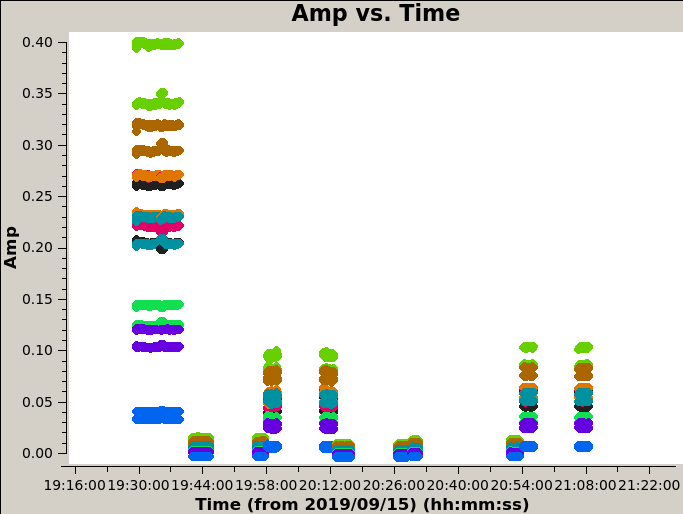

In [19]:
Image(filename=root + "/plots/dataplots/single_chans_amp_vs_time.png")

## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data. The gain calibrations are done with a single channel per spectral window.

In [20]:
def plot_two_cols(im1, im2):
    """ 
    Plot two image side by side. E.g phase and amplitude.
    """
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))

    if os.path.exists(im1):
        img_1 = mpimg.imread(im1)
        ax[0].imshow(img_1)

    if os.path.exists(im2):
        img_2 = mpimg.imread(im2)
        ax[1].imshow(img_2)

### Specify Gain Tables

In [21]:
# specify calibration table names
rnd = 0
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [22]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

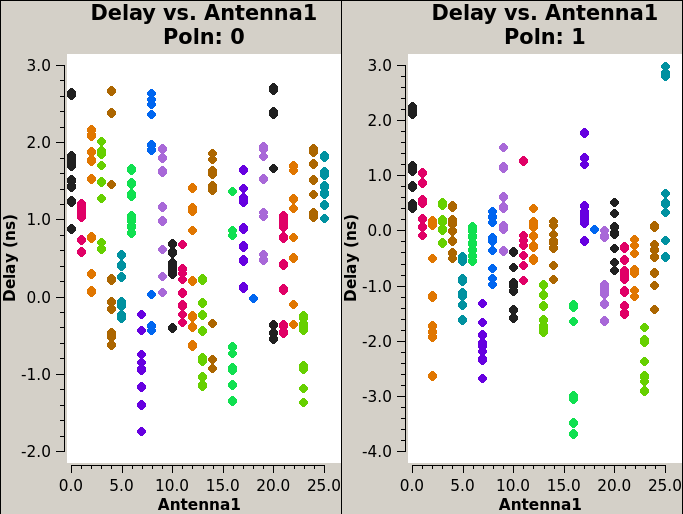

In [23]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [24]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [25]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [26]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

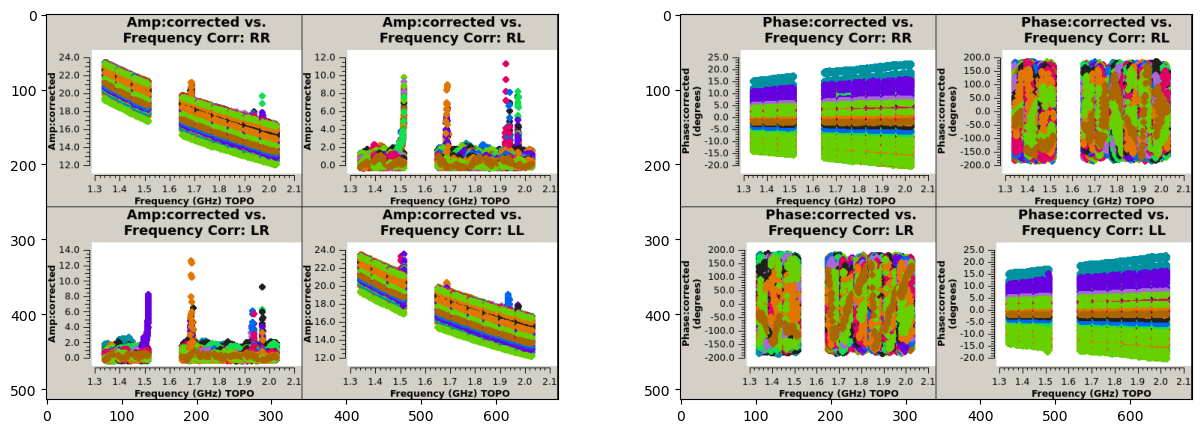

In [27]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_0_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [28]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [29]:
rnd=0
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 0:

field 3C147
Before: 51.0740, After: 72.8044

antenna ea01
Before: 46.9387, After: 70.5068

antenna ea02
Before: 46.9622, After: 70.5068

antenna ea03
Before: 46.9435, After: 70.5068

antenna ea04
Before: 46.9511, After: 70.5068

antenna ea05
Before: 46.9387, After: 70.5068

antenna ea06
Before: 46.9622, After: 70.5068

antenna ea07
Before: 46.9435, After: 70.5068

antenna ea08
Before: 46.9511, After: 70.5068

antenna ea09
Before: 46.9387, After: 70.5068

antenna ea10
Before: 46.9622, After: 70.5068

antenna ea11
Before: 46.9435, After: 70.5068

antenna ea12
Before: 47.1224, After: 70.6238

antenna ea13
Before: 46.9387, After: 70.5068

antenna ea14
Before: 46.9622, After: 70.5068

antenna ea15
Before: 46.9435, After: 70.5068

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 46.9387, After: 70.5068

antenna ea18
Before: 47.2379, After: 70.7826

antenna ea19
Before: 46.9435, After: 70.5068

antenna

## First Round of Flagging on Primary Calibrator
The first round of flagging is performed on the primary calibrator only. The flagging routine runs RFlag with timedevscale=5.0, freqdevscale=5.0 and freqfit=line on a ABS_RL, ABS_LR, ABS_LL, ABS_RR, REAL_LL, REAL_RR, IMAG_LL and IMAG_RR, where for the real and imaginary parts RFLag is performed on the residual (corrected-model) data. TFCrop is run with timecutoff=4.0 and freqcutoff=4.0 on ABS_RL, ABS_LR, ABS_LL and ABS_RR. Flags are extended across polarisations. The plots below show the amplitudes and phases of the calibrators before and after flagging respectively.

### Before Flagging

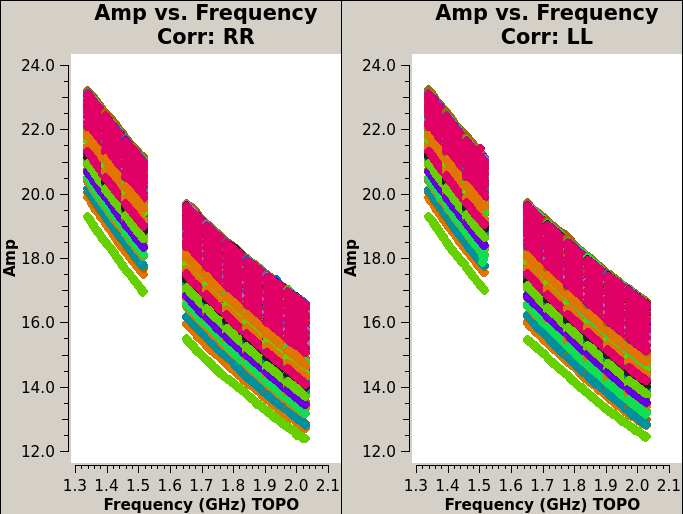

In [30]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

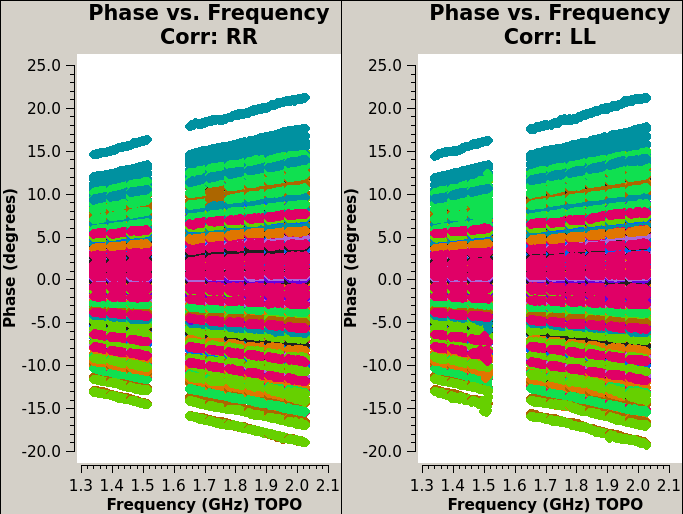

In [31]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

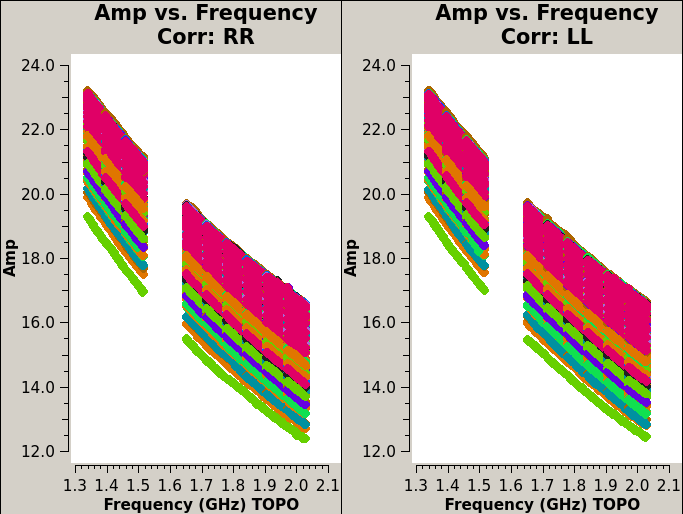

In [32]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

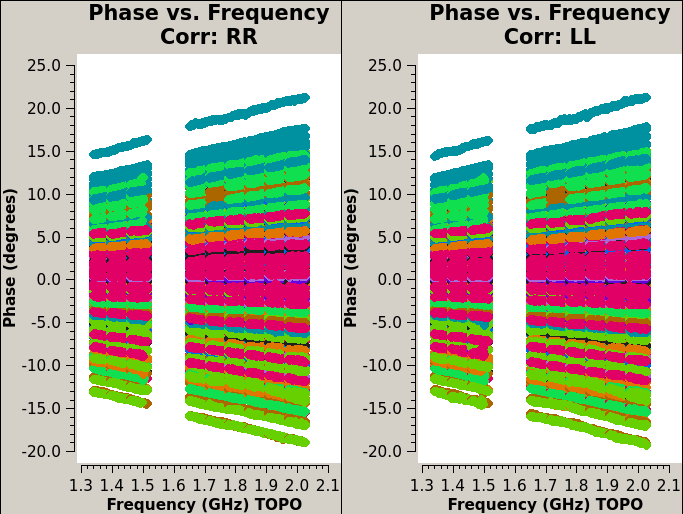

In [33]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [34]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field 3C147
Before: 72.8044, After: 73.0340

antenna ea01
Before: 70.5068, After: 70.7095

antenna ea02
Before: 70.5068, After: 70.6547

antenna ea03
Before: 70.5068, After: 70.6488

antenna ea04
Before: 70.5068, After: 70.6258

antenna ea05
Before: 70.5068, After: 70.6191

antenna ea06
Before: 70.5068, After: 70.7094

antenna ea07
Before: 70.5068, After: 70.6953

antenna ea08
Before: 70.5068, After: 70.7321

antenna ea09
Before: 70.5068, After: 70.6846

antenna ea10
Before: 70.5068, After: 70.7293

antenna ea11
Before: 70.5068, After: 70.6206

antenna ea12
Before: 70.6238, After: 70.9496

antenna ea13
Before: 70.5068, After: 70.6503

antenna ea14
Before: 70.5068, After: 70.6438

antenna ea15
Before: 70.5068, After: 70.6518

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 70.5068, After: 70.7343

antenna ea18
Before: 70.7826, After: 72.2774

antenna ea19
Before: 70.5068, After: 70.7529

antenn

## Semi-Final Calibration
The steps from the intitial calibration are repeated. 

### Specify Gain Tables

In [35]:
# specify calibration table names
rnd = 1
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration

In [36]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

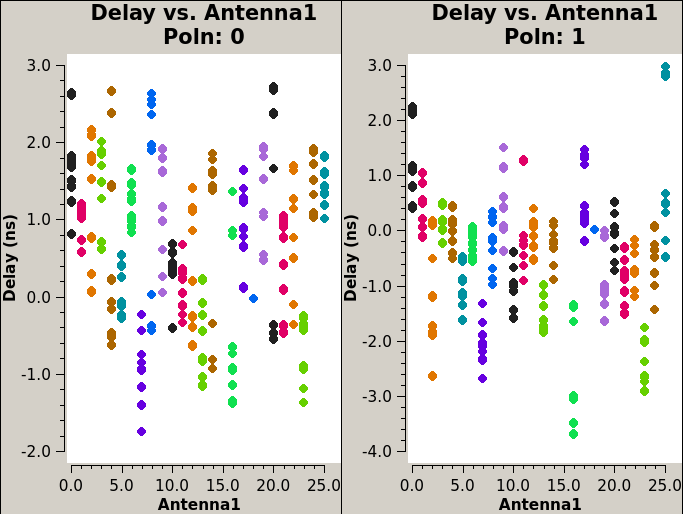

In [37]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [38]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [39]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [40]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

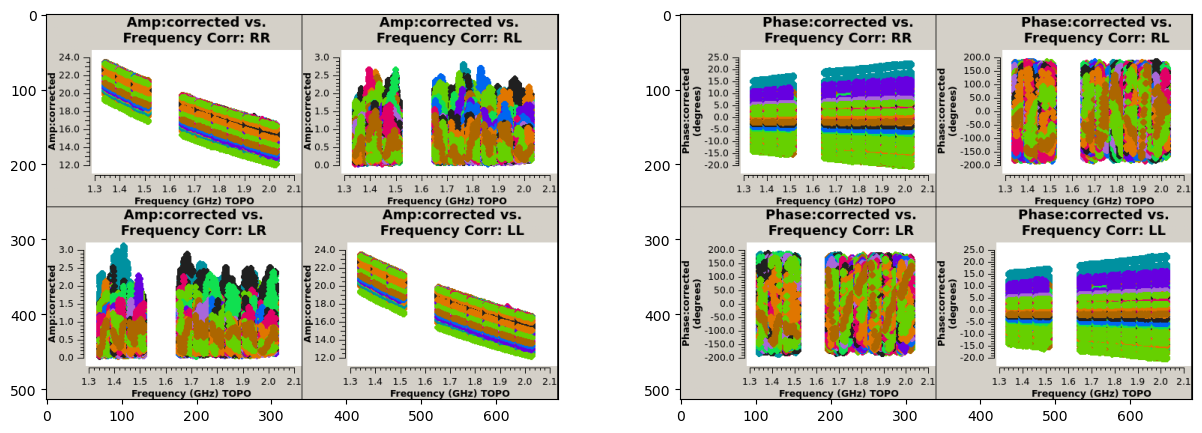

In [41]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_{rnd}_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_{rnd}_phase_vs_freq_CorrRR,RL,LR,LL.png"
)


#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [42]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_{rnd}_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flag Bandpass Outliers (RFI)

In [43]:
"""
casatasks.flagdata(ms, spw="5:0~12", reason="Manual Frequency Flagging", flagbackup=False)
casatasks.flagdata(ms, spw="10:26~34", reason="Manual Frequency Flagging", flagbackup=False)
casatasks.flagdata(ms, spw="14:28~37", reason="Manual Frequency Flagging", flagbackup=False)
"""

'\ncasatasks.flagdata(ms, spw="5:0~12", reason="Manual Frequency Flagging", flagbackup=False)\ncasatasks.flagdata(ms, spw="10:26~34", reason="Manual Frequency Flagging", flagbackup=False)\ncasatasks.flagdata(ms, spw="14:28~37", reason="Manual Frequency Flagging", flagbackup=False)\n'

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [44]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 1:

field 3C147
Before: 73.0340, After: 73.0341

antenna ea01
Before: 70.7095, After: 70.7095

antenna ea02
Before: 70.6547, After: 70.6547

antenna ea03
Before: 70.6488, After: 70.6488

antenna ea04
Before: 70.6258, After: 70.6258

antenna ea05
Before: 70.6191, After: 70.6191

antenna ea06
Before: 70.7094, After: 70.7097

antenna ea07
Before: 70.6953, After: 70.6960

antenna ea08
Before: 70.7321, After: 70.7321

antenna ea09
Before: 70.6846, After: 70.6846

antenna ea10
Before: 70.7293, After: 70.7293

antenna ea11
Before: 70.6206, After: 70.6208

antenna ea12
Before: 70.9496, After: 70.9496

antenna ea13
Before: 70.6503, After: 70.6503

antenna ea14
Before: 70.6438, After: 70.6438

antenna ea15
Before: 70.6518, After: 70.6521

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 70.7343, After: 70.7343

antenna ea18
Before: 72.2774, After: 72.2789

antenna ea19
Before: 70.7529, After: 70.7529

antenna

## Second Round of Flagging
The flagging is repeated, but this time on all calibrators.

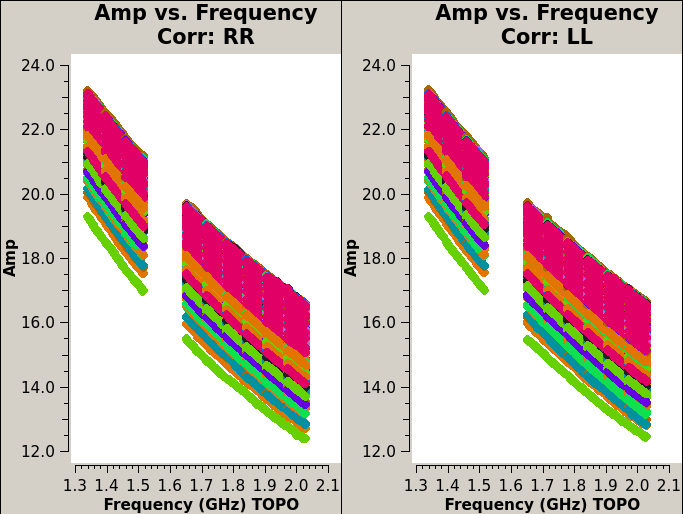

In [45]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

In [ ]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

In [ ]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

In [ ]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

In [ ]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

In [ ]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

In [ ]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

In [ ]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Flagging Summary

In [ ]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

In [ ]:
summary_before = np.load(root + f"/output/phasecal_round_0_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_round_0_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

In [ ]:
summary_before = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

## Flux Bootstraping
The flux scale of the primary calibrator is transfered to the secondary calibrators. An initial phase and amplitude gain calibration is performed on the secondary phase calibrators. First, a per integration phase calibration is performed, and then a phase and amplitude gain calibration on a long interval (scan). The latter is done twice, once by keeping the amplitudes normalised and once unrestrained. The formed is used to flag bad solutions.
After the initial calibration, a spectral index model is fitted to the secondary calibrators. 

### Plot Gain Calibrations

In [ ]:
# specify calibration tables
short_gain_table = f"{name}_short.G"
long_gain_table = f"{name}_long.G"
flux_gain_table = f"{name}_fluxgain.G"

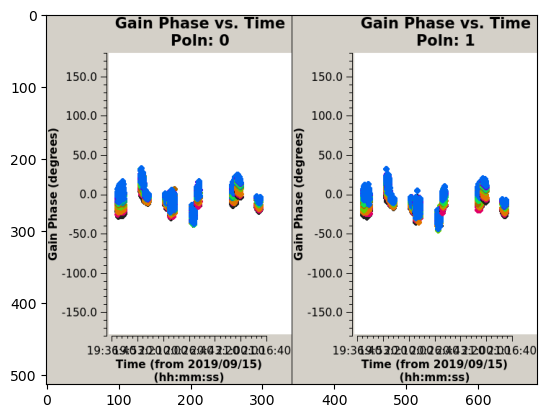

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_short_gain(ant)>

In [57]:
def plot_short_gain(ant):
    img = mpimg.imread(root + f"/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_short_gain, ant=(0, conf["ants"]-1))

In [58]:
def plot_long_gain(ant):
    plot_two_cols(
        root + f"/plots/calplots/{long_gain_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{long_gain_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_long_gain(ant)>

In [59]:
def plot_flux_gain(ant):
    plot_two_cols(
        root + f"/plots/calplots/{flux_gain_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{flux_gain_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_flux_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_flux_gain(ant)>

### Plot Model
Check that the models have reasonable flux densities and spectral indices.

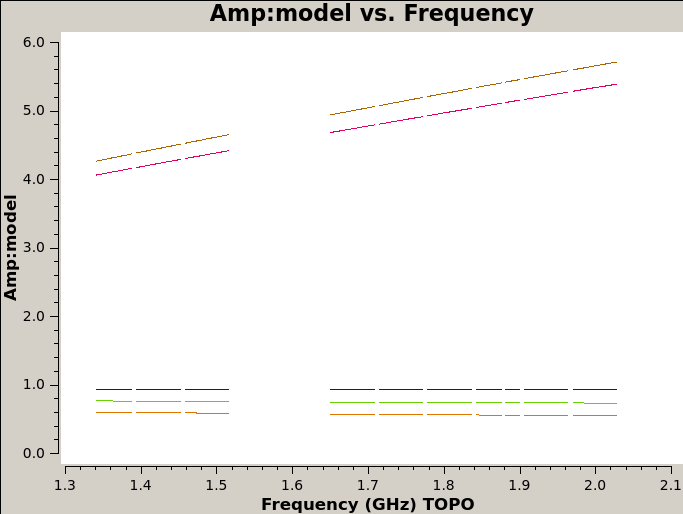

In [85]:
Image(filename=root + "/plots/dataplots/model_amp_vs_freq.png")

### Plot Residuals
Check that the residuals are small.

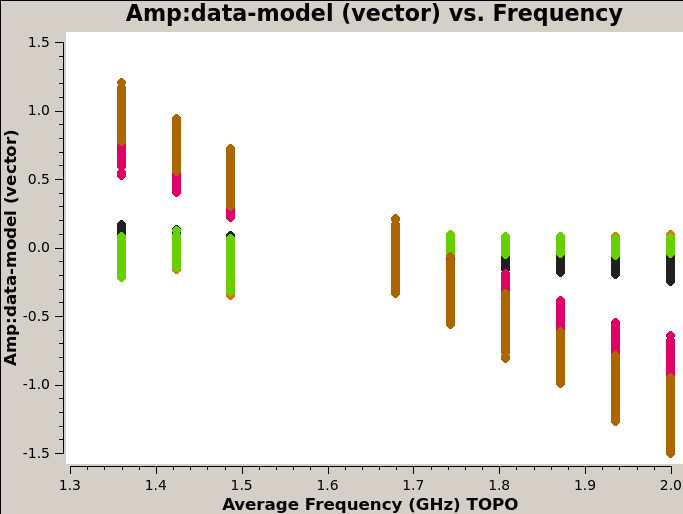

In [61]:
Image(filename=root + "/plots/dataplots/model_amp_vs_freq_residual.png")

### Summary

In [62]:
summary_before = np.load(root + f"/output/fluxboot_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxboot_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flux bootstrapping:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flux bootstrapping:

field 3C147
Before: 12.6017, After: 12.6017

field J1057-2433
Before: 14.0930, After: 14.0930

field J1130-1449
Before: 13.4796, After: 13.4796

field J1246-0730
Before: 14.4036, After: 14.4036

field J1309+1154
Before: 13.0455, After: 13.0455

field J1347+1217
Before: 13.0893, After: 13.0893

scan 10
Before: 14.5295, After: 14.5295

scan 12
Before: 14.2068, After: 14.2068

scan 13
Before: 13.0426, After: 13.0426

scan 16
Before: 13.0481, After: 13.0481

scan 17
Before: 13.1044, After: 13.1044

scan 19
Before: 13.0749, After: 13.0749

scan 2
Before: 12.6354, After: 12.6354

scan 3
Before: 12.5581, After: 12.5581

scan 4
Before: 14.1025, After: 14.1025

scan 6
Before: 14.0746, After: 14.0746

scan 7
Before: 13.5770, After: 13.5770

scan 9
Before: 13.3842, After: 13.3842

antenna ea01
Before: 13.0790, After: 13.0790

antenna ea02
Before: 13.0403, After: 13.0403

antenna ea03
Before: 12.9121, After: 12.9121

antenna ea04
Befor

## Final Calibration
First, the initial calibration (delay and bandpass) are repeated on the primary calibrator. Then, the final gains of the calibrators are derived.

### Specify Gain Tables

In [63]:
# specify calibration table names
rnd = 2
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

fluxcal_phase_table = f"{name}_fluxcal_phase.Gfinal"
short_gain_table = f"{name}_short.Gfinal"
amp_gain_table = f"{name}_amp.Gfinal"
phase_gain_table = f"{name}_phase.Gfinal"

### Delay Initial Gain Calibration

In [64]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

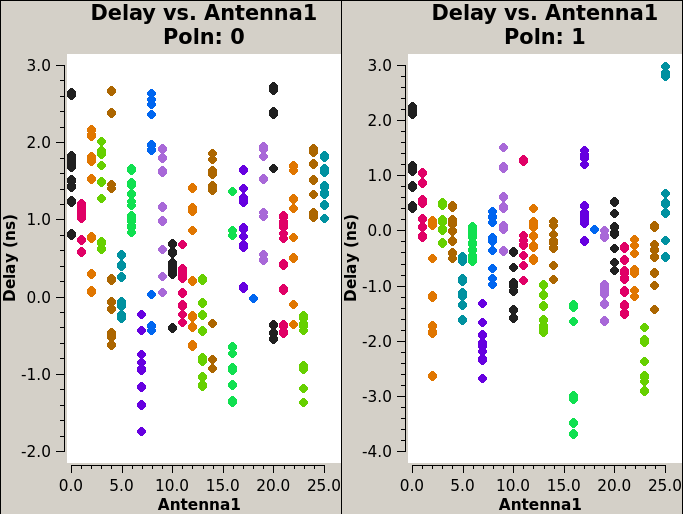

In [65]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [66]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [67]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [68]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flux Calibrator Final Gain Phase

In [69]:
def plot_final_fluxcal_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{fluxcal_phase_table}_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_fluxcal_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_fluxcal_phase(ant)>

### Short Interval Gain Calibration
This is an initial calibration done on a per-integration basis on the calibrators.

In [70]:
def plot_final_short_gain_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_short_gain_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_short_gain_phase(ant)>

### Long Interval Gain Calibration
The gain amplitudes of the calibrators of solved for using the initial gain phase calibration above.

In [71]:
def plot_final_long_gain(ant):
    plot_two_cols(
        root + f'/plots/calplots/{amp_gain_table}_amp_ant_{ant}_Poln0,1.png',
        root + f'/plots/calplots/{amp_gain_table}_phase_ant_{ant}_Poln0,1.png'
    )

interact(plot_final_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain(ant)>

### Phase Calibration
Derive the final gain phases of the calibrators. That of the primary calibrator should be close to zero, since it was already derived and applied earlier on.

In [72]:
def plot_final_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{phase_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase(ant)>

### Flagging Summary

In [73]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after final delay and bandpass calibration:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after final delay and bandpass calibration:

field 3C147
Before: 73.0340, After: 73.0341

antenna ea01
Before: 70.7095, After: 70.7095

antenna ea02
Before: 70.6547, After: 70.6547

antenna ea03
Before: 70.6488, After: 70.6488

antenna ea04
Before: 70.6258, After: 70.6258

antenna ea05
Before: 70.6191, After: 70.6191

antenna ea06
Before: 70.7094, After: 70.7097

antenna ea07
Before: 70.6953, After: 70.6960

antenna ea08
Before: 70.7321, After: 70.7321

antenna ea09
Before: 70.6846, After: 70.6846

antenna ea10
Before: 70.7293, After: 70.7293

antenna ea11
Before: 70.6206, After: 70.6208

antenna ea12
Before: 70.9496, After: 70.9496

antenna ea13
Before: 70.6503, After: 70.6503

antenna ea14
Before: 70.6438, After: 70.6438

antenna ea15
Before: 70.6518, After: 70.6521

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 70.7343, After: 70.7343

antenna ea18
Before: 72.2774, After: 72.2789

antenna ea19
Before: 70.7529, After: 70.7529

In [74]:
summary_before = np.load(root + f"/output/applycal_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/applycal_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after applying final calibration:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after applying final calibration:

field 3C147
Before: 73.0715, After: 73.0715

field J1057-2433
Before: 74.1009, After: 74.1009

field J1130-1449
Before: 65.9374, After: 65.9374

field J1246-0730
Before: 66.3380, After: 66.3380

field J1309+1154
Before: 69.6714, After: 69.6714

field J1347+1217
Before: 65.9579, After: 65.9579

field QSO J1034-1425
Before: 59.6219, After: 59.6219

field QSO J1110-1329
Before: 59.0330, After: 59.0330

field QSO J1254-0014
Before: 59.3518, After: 59.3518

field QSO J1306+0356
Before: 60.0270, After: 60.0270

field QSO J1319+0950
Before: 59.2167, After: 59.2167

field QSO J1342+0928
Before: 58.6766, After: 58.6766

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 66.6563, After: 66.6563

scan 11
Before: 59.3518, After: 59.3518

scan 12
Before: 65.8304, After: 65.8304

scan 13
Before: 74.1722, After: 74.1722

scan 14
Before: 60.0270, After: 60.0270

scan 15
Before: 59.2167, After: 59.2167

scan 16
Before: 64.258

## Target Flags
Now that the final calibration tables have been derived and applied to the data, the automated flagging routine is run on the target fields.

### Before Flagging

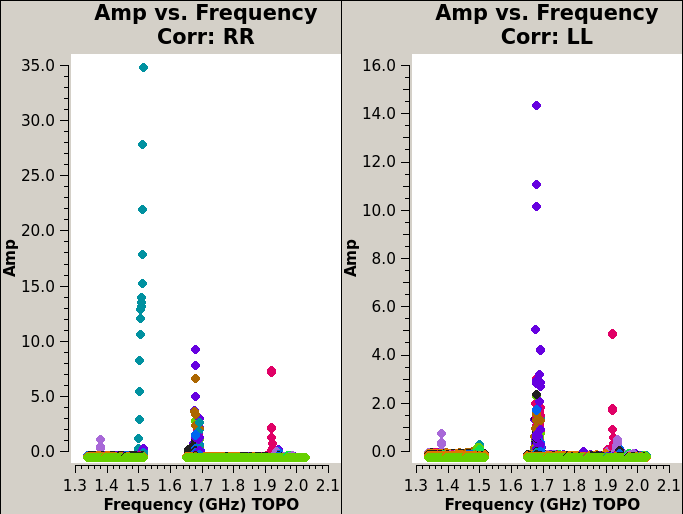

In [75]:
Image(filename=root + "/plots/dataplots/before_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### After Flagging

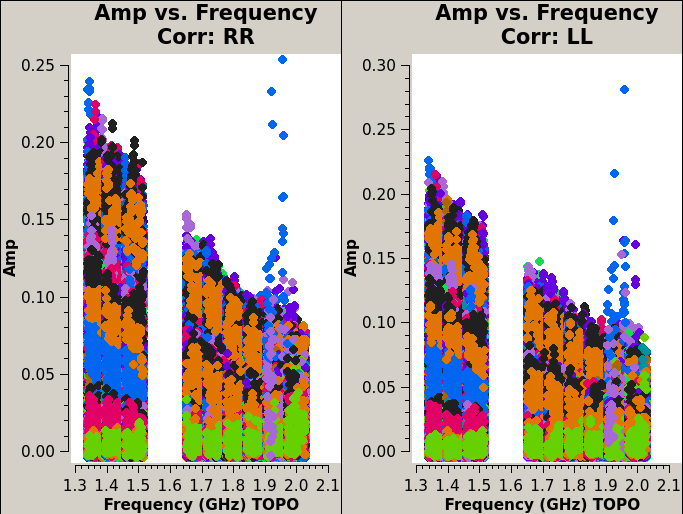

In [76]:
Image(filename=root + "/plots/dataplots/after_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### Summary

In [77]:
rnd=0
summary_before = np.load(root + f"/output/targets_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/targets_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the flux calibrator:

field QSO J1034-1425
Before: 59.6219, After: 61.1137

field QSO J1110-1329
Before: 59.0330, After: 60.3441

field QSO J1254-0014
Before: 59.3518, After: 61.2207

field QSO J1306+0356
Before: 60.0270, After: 60.9532

field QSO J1319+0950
Before: 59.2167, After: 60.1082

field QSO J1342+0928
Before: 58.6766, After: 59.5877

scan 11
Before: 59.3518, After: 61.2207

scan 14
Before: 60.0270, After: 60.9532

scan 15
Before: 59.2167, After: 60.1082

scan 18
Before: 58.6766, After: 59.5877

scan 5
Before: 59.6219, After: 61.1137

scan 8
Before: 59.0330, After: 60.3441

antenna ea01
Before: 55.9760, After: 56.9654

antenna ea02
Before: 55.9760, After: 56.8877

antenna ea03
Before: 55.9760, After: 56.7770

antenna ea04
Before: 55.9760, After: 57.3510

antenna ea05
Before: 55.9760, After: 56.5670

antenna ea06
Before: 55.9760, After: 57.0222

antenna ea07
Before: 55.9760, After: 56.5821

antenna ea08
Before: 55.9760, After: 57.2587

an

## Summary Plots
These plots show the corrected amplitudes and phases of all fields as a function of uv-distance and frequency. The values plotted against uv-distance are colorised by spectral window while those plotted against frequency are colorised by antenna number. Remaining RFI should be flagged manually in CASA.

In [78]:
field_dict = vladata.get_field_names(ms)
fields = field_dict["calibrators"] + "," + field_dict["targets"]

3C147


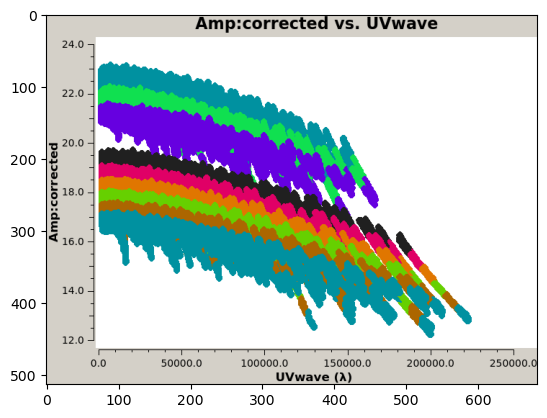

J1057-2433


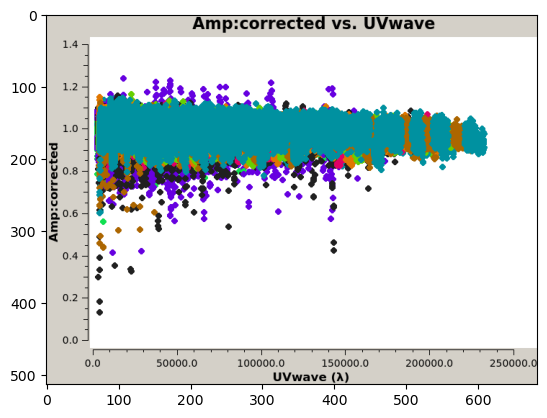

J1130-1449


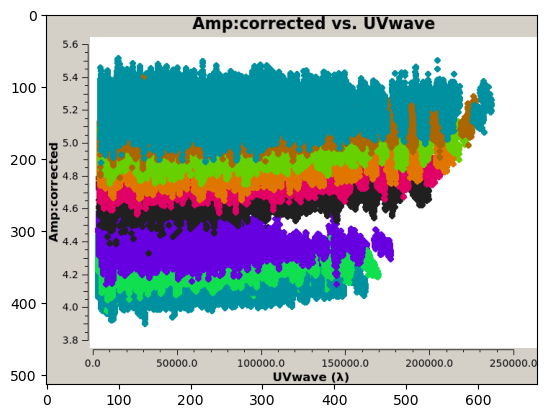

J1246-0730


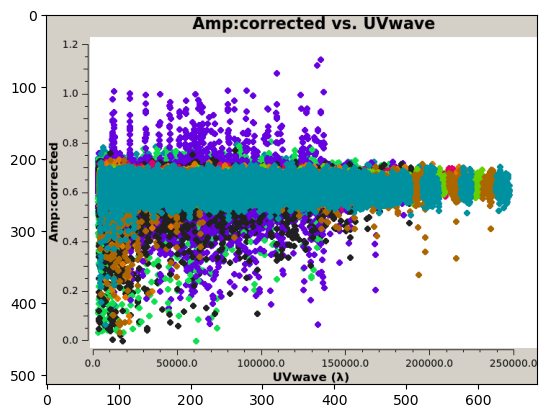

J1309+1154


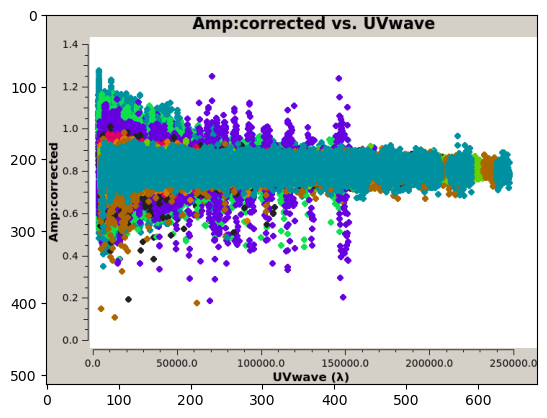

J1347+1217


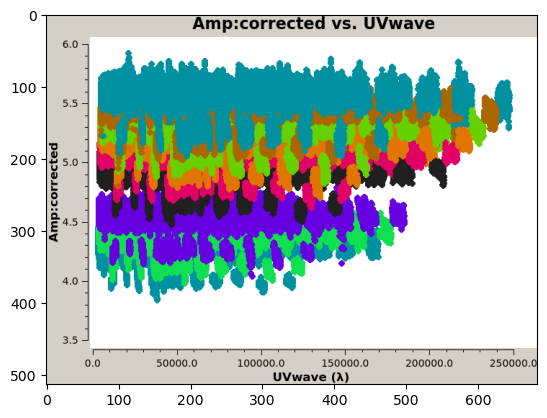

QSO J1034-1425


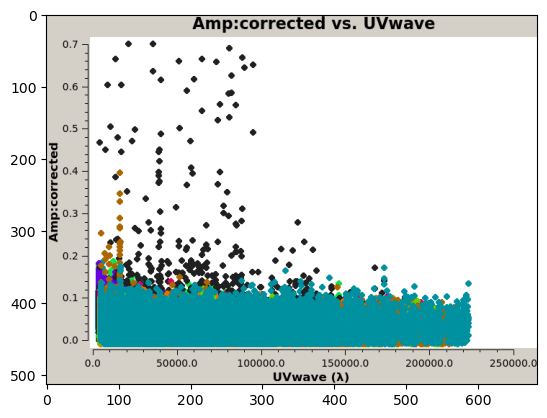

QSO J1110-1329


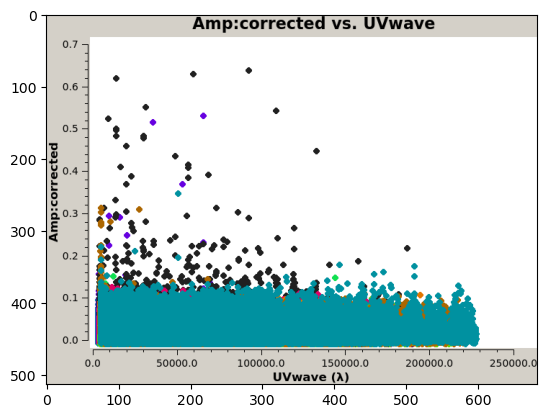

QSO J1254-0014


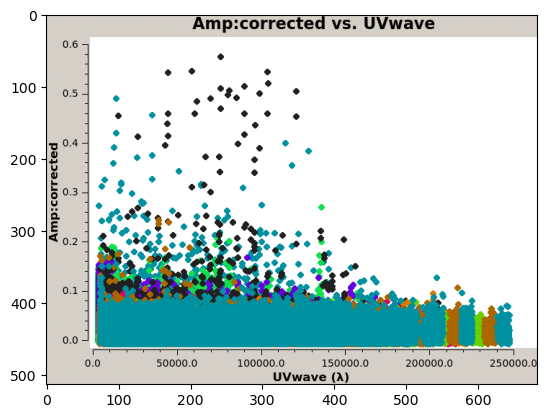

QSO J1306+0356


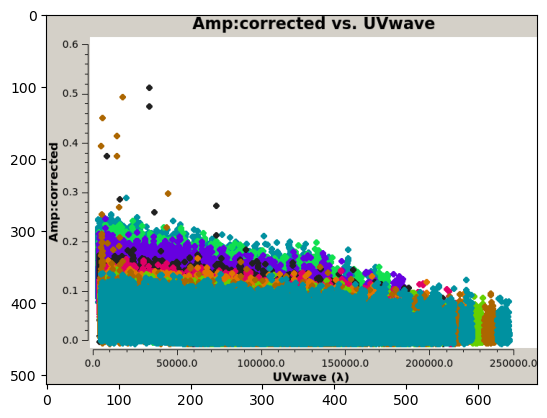

QSO J1319+0950


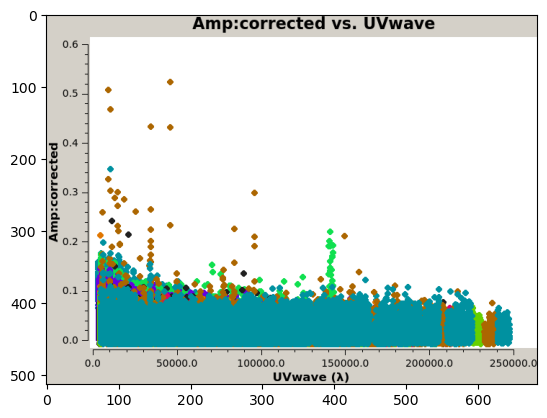

QSO J1342+0928


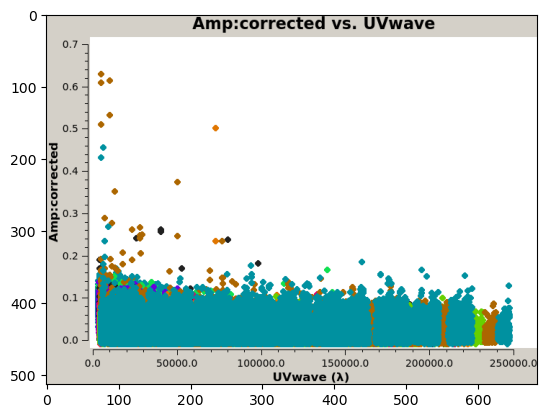

In [79]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_uvdist_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

3C147


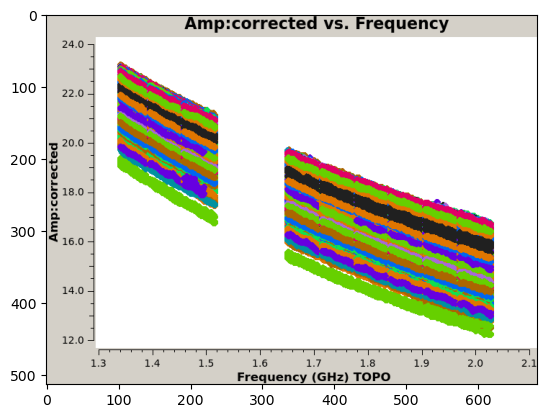

J1057-2433


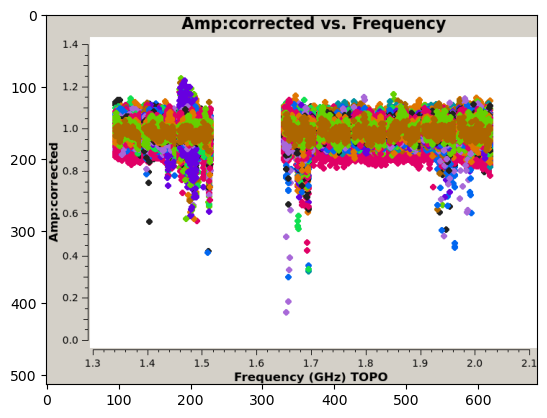

J1130-1449


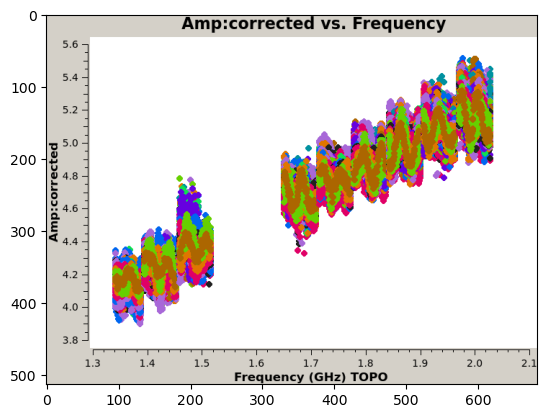

J1246-0730


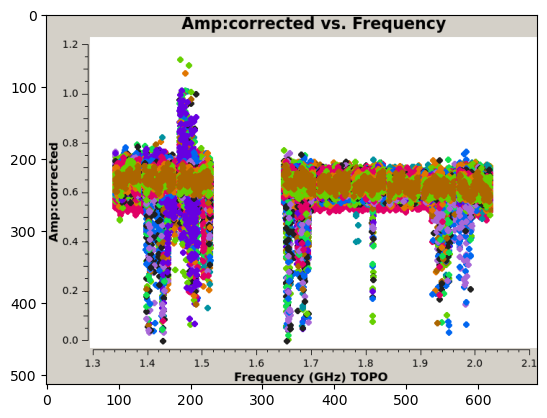

J1309+1154


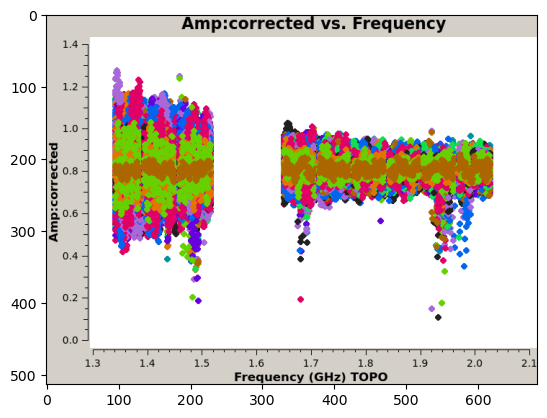

J1347+1217


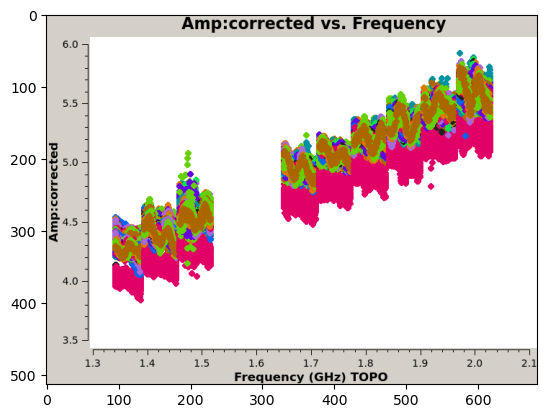

QSO J1034-1425


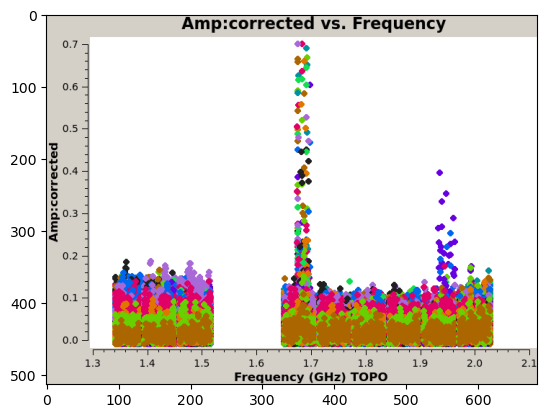

QSO J1110-1329


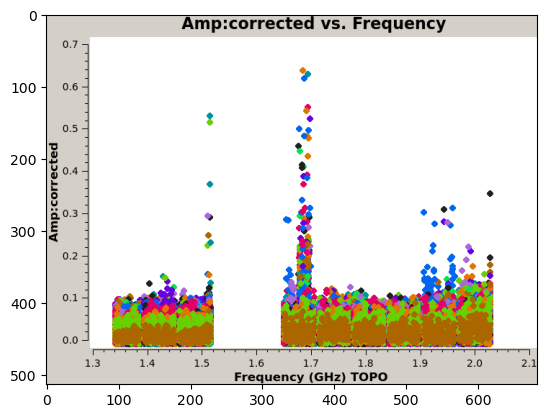

QSO J1254-0014


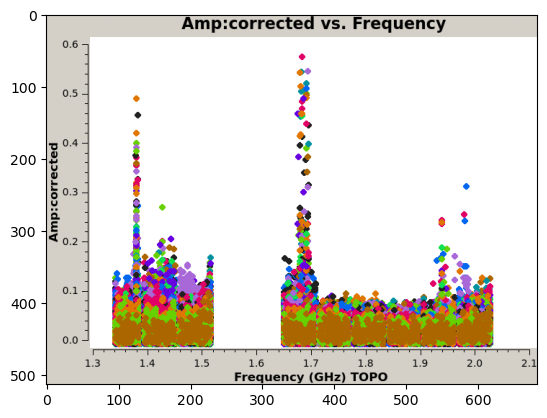

QSO J1306+0356


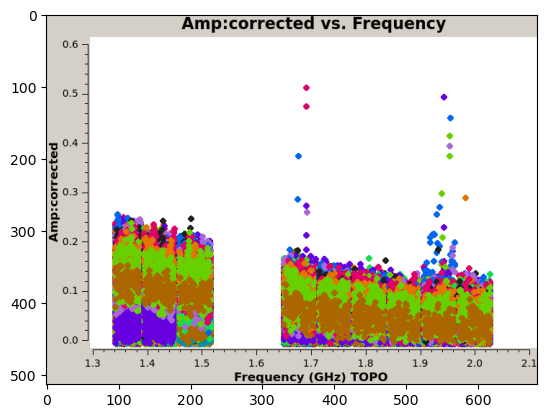

QSO J1319+0950


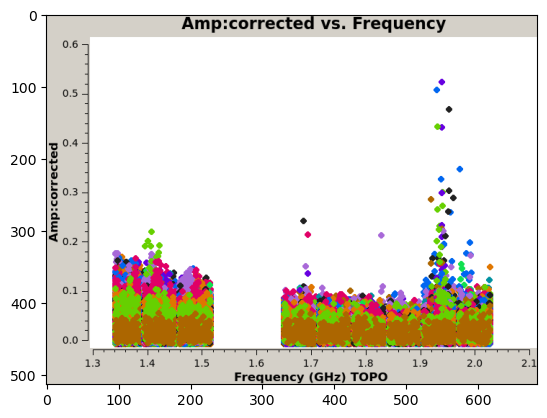

QSO J1342+0928


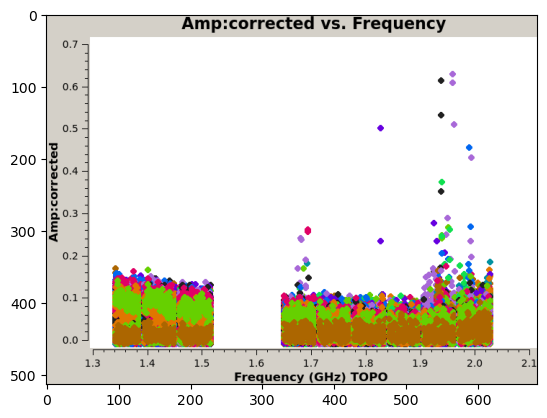

In [80]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

3C147


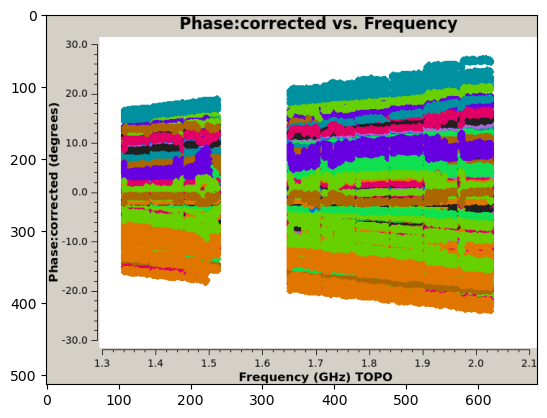

J1057-2433


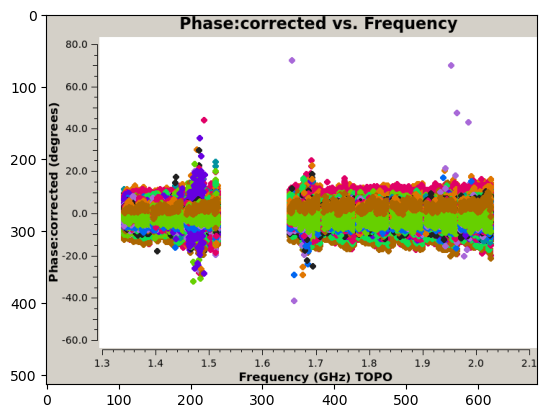

J1130-1449


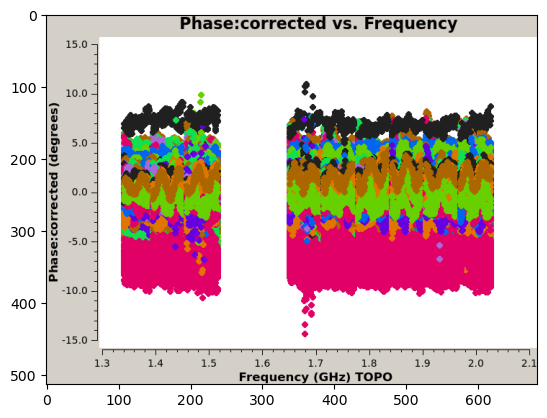

J1246-0730


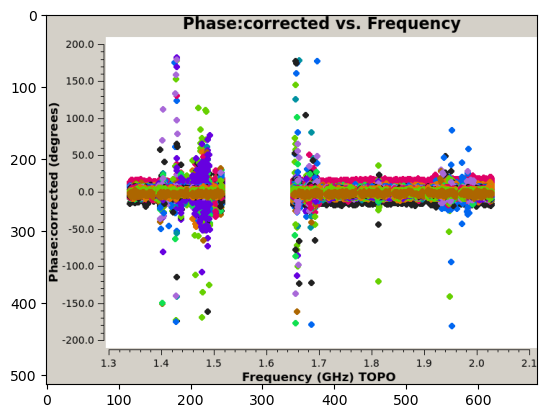

J1309+1154


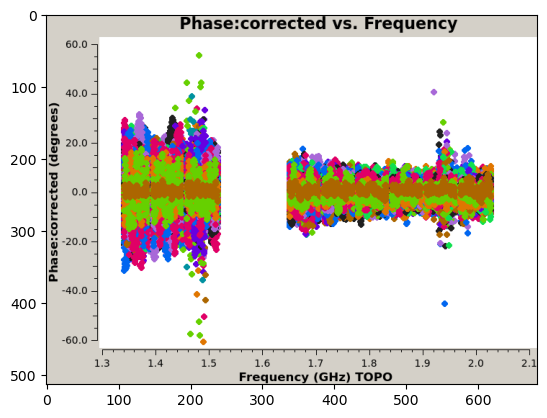

J1347+1217


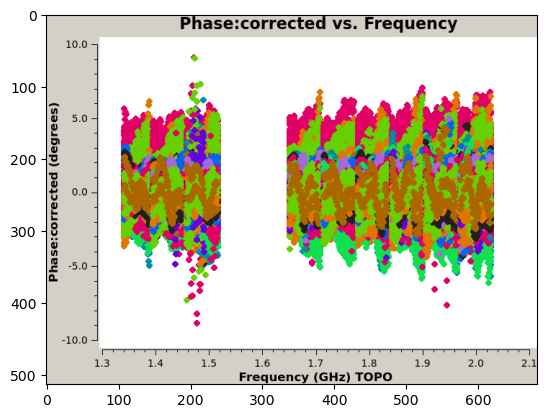

QSO J1034-1425


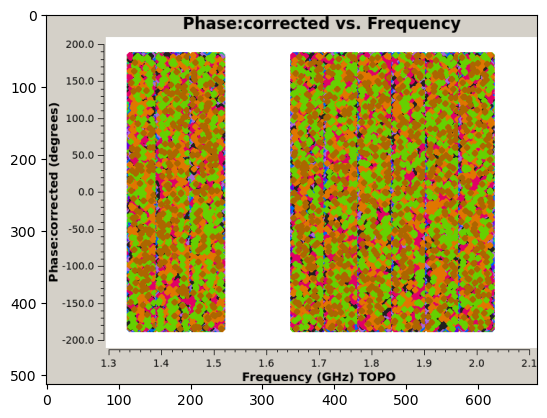

QSO J1110-1329


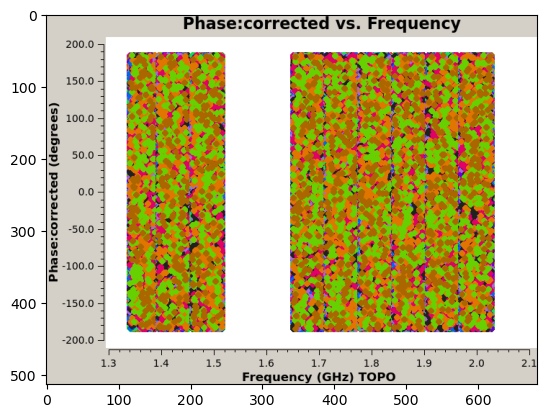

QSO J1254-0014


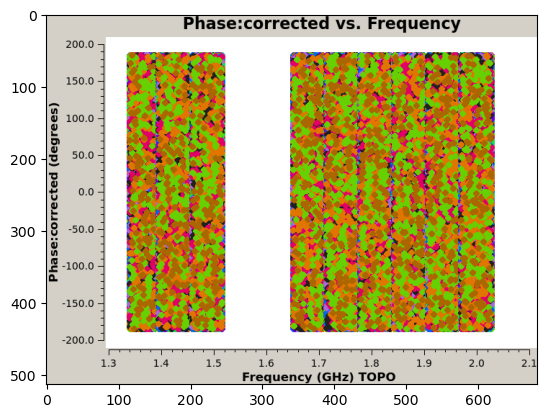

QSO J1306+0356


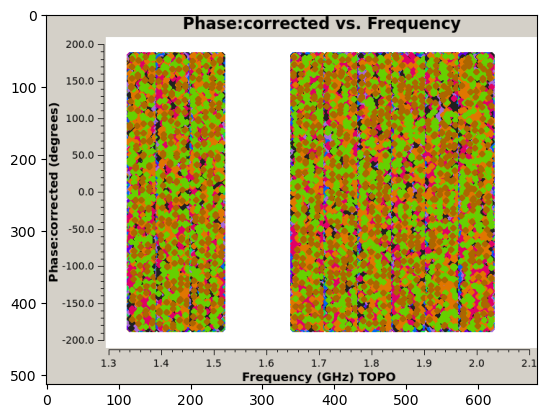

QSO J1319+0950


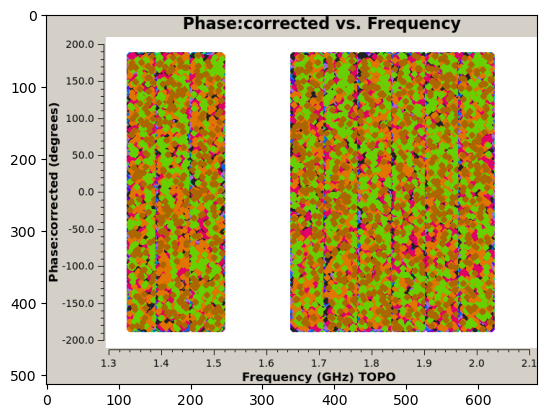

QSO J1342+0928


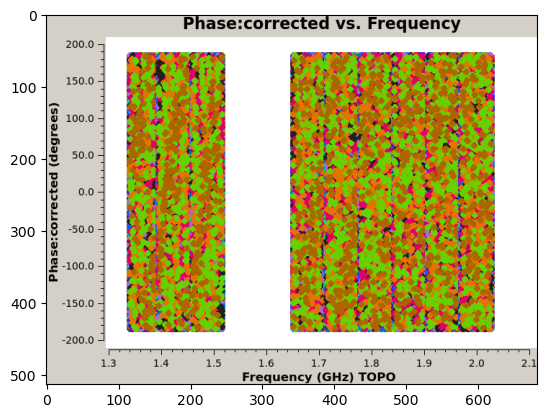

In [81]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_phase_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [82]:

with h5py.File(root + f"/output/z_score_corrected.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

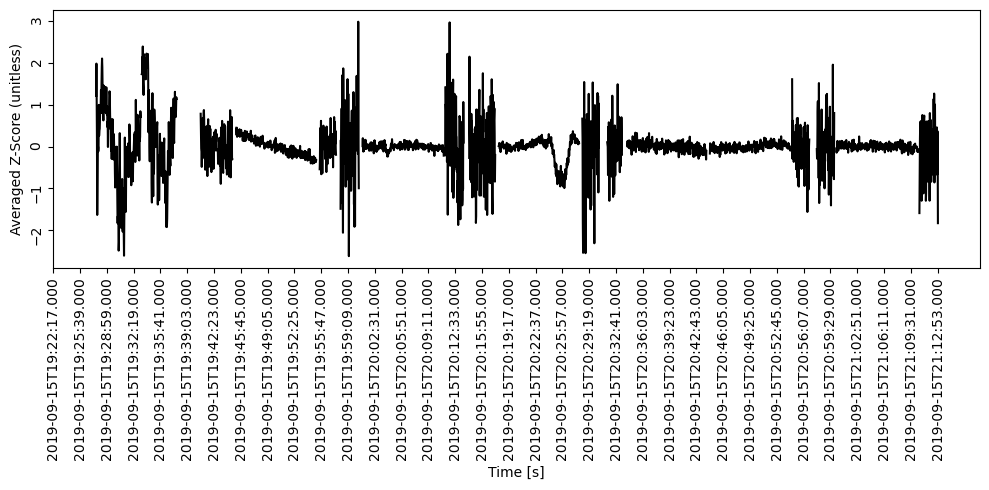

In [83]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

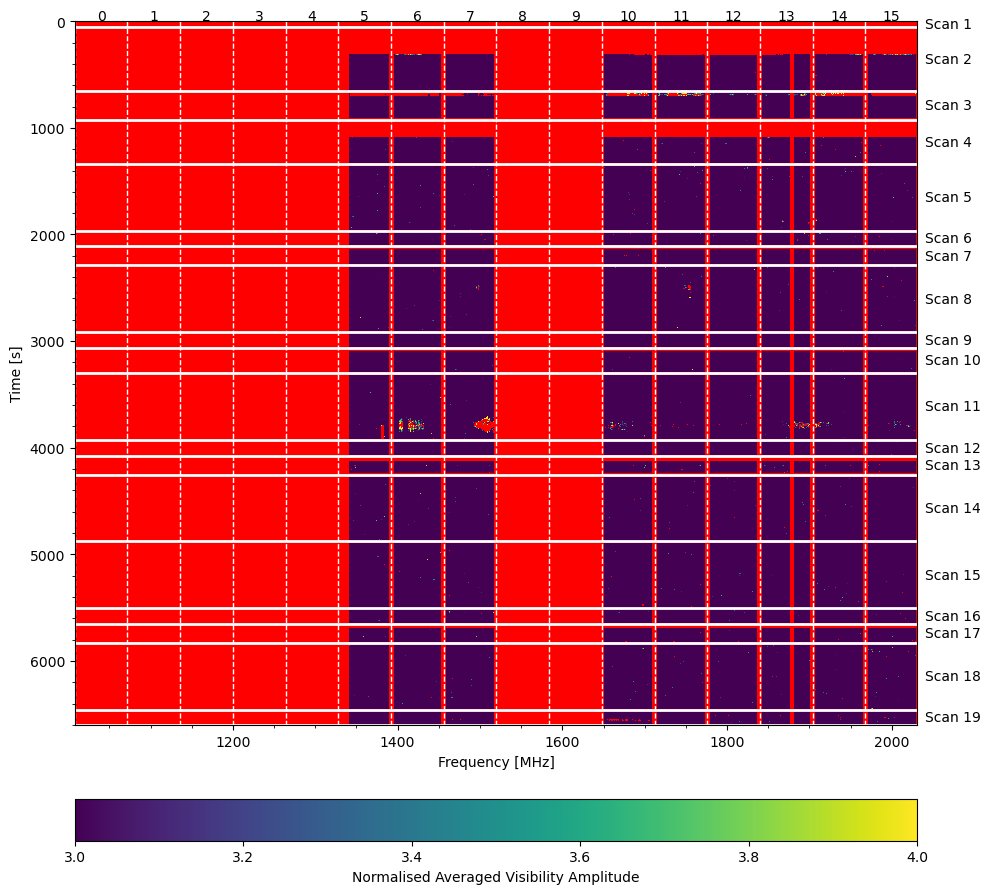

In [84]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=3, vmax=4, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")